# Demo Notebook on how to load the transfer core and train a model

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import neuralpredictors as neur
from neuralpredictors.data.datasets import StaticImageSet, FileTreeDataset

# Build the dataloaders

The dataloaders object is a dictionary of 3 dictionaries: train, validation and test. Each of them contains the respective data from all datasets combined that were specified in paths. Here we only provide one dataset. While the responses are normalized, we exclude the input images from normalization. The following config was used in the paper (all arguments not in the config have the default value of the function). 

In [34]:
from lurz2020.datasets.mouse_loaders import static_loaders

paths = [r'D:\inception_loop\original_code\lurz2020\static20457-5-9-preproc0']

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': 1, 
                  'cuda': True,
                  'normalize': True,
                  'include_eye_position': True,
                  'exclude': "images"}

dataloaders = static_loaders(**dataset_config)
dat = FileTreeDataset(r'D:\inception_loop\original_code\lurz2020\static20457-5-9-preproc0', "images", "responses")

### Look at the data

In [35]:
tier = 'train'
dataset_name = '20457-5-9-0'

images, responses, eye = [], [], []
for data_names in dataloaders[tier][dataset_name]:
    images.append(data_names[0].squeeze().cpu().data.numpy())
    responses.append(data_names[1].squeeze().cpu().data.numpy())
    
images = np.vstack(images)
responses = np.vstack(responses)

print('The \"{}\" set of dataset \"{}\" contains the responses of {} neurons to {} images'.format(tier, dataset_name, responses.shape[1], responses.shape[0]))

The "train" set of dataset "20457-5-9-0" contains the responses of 5335 neurons to 4472 images


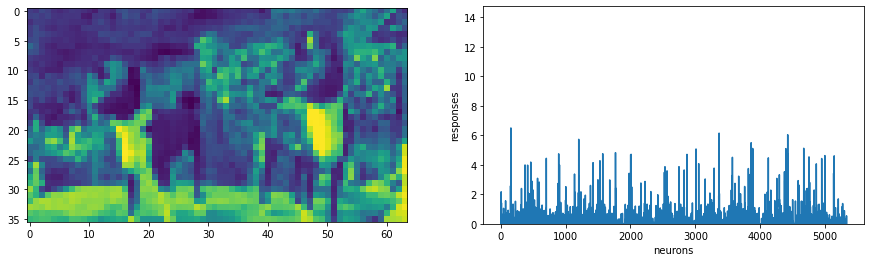

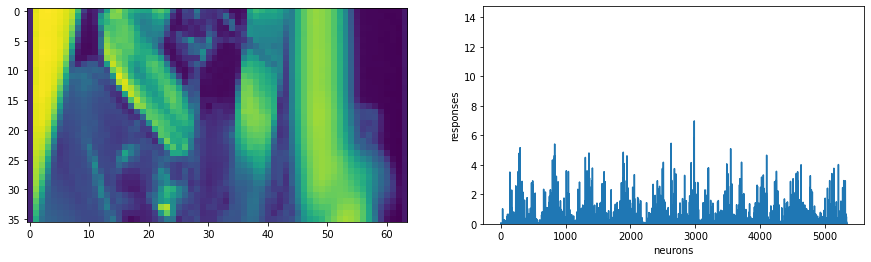

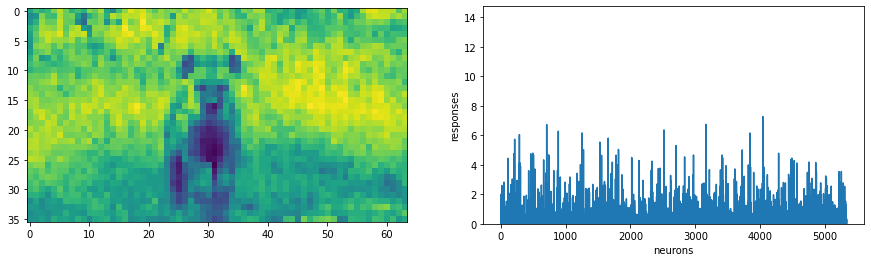

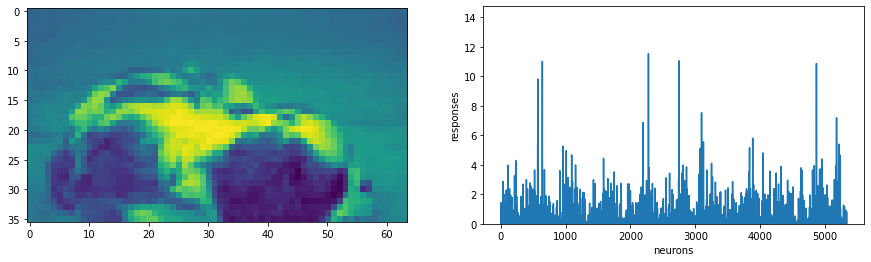

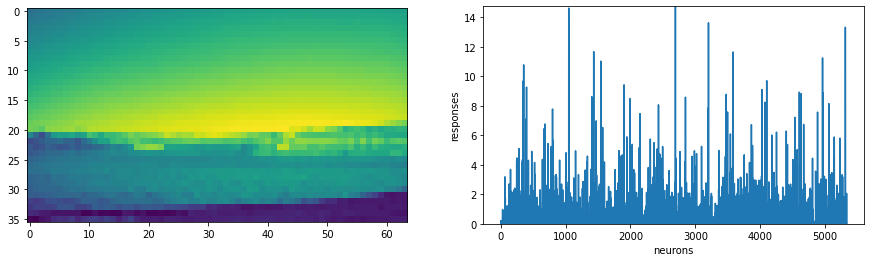

In [15]:
# show some example images and the neural responses
n_images = 5
max_response = responses[:n_images].max()

for i in range(n_images):
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    axs[0].imshow(images[i])
    axs[1].plot(responses[i])
    axs[1].set_xlabel('neurons')
    axs[1].set_ylabel('responses')
    axs[1].set_ylim([0, max_response])
    plt.show()

# Build the model

If you want to load the transfer core later on, the arguments in the model config that concern the architecture of the model can not be changed. The following config was used in the paper (all arguments not in the config have the default value of the function).

In [36]:
from lurz2020.models.models import se2d_fullgaussian2d

#model_config = {'init_mu_range': 0.55,
#                'init_sigma': 0.4,
#                'input_kern': 15,
#                'hidden_kern': 13,
#                'gamma_input': 1.0,
#                'grid_mean_predictor': {'type': 'cortex',
#                                        'input_dimensions': 2,
#                                        'hidden_layers': 0,
#                                        'hidden_features': 0,
#                                        'final_tanh': False},
#                'gamma_readout': 2.439}

model_config = {'init_mu_range': 0.55,
                'init_sigma': 0.4,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': None,
                'gamma_readout': 2.439}

model = se2d_fullgaussian2d(**model_config, dataloaders=dataloaders, seed=1)

## Load the weights of the transfer core

This will load the weights of the transfer core onto the model that you built above. The argument `strict=False` ensures that only matching keys are loaded. The readout keys are thus discarded.

In [37]:
transfer_model = torch.load('D://inception_loop/original_code/Lurz_2020_code/notebooks/models/transfer_model.pth.tar') 
model.load_state_dict(transfer_model, strict=False)

_IncompatibleKeys(missing_keys=['shifter.mlp.0.weight', 'shifter.mlp.0.bias', 'shifter.mlp.2.weight', 'shifter.mlp.2.bias', 'shifter.mlp.4.weight', 'shifter.mlp.4.bias', 'readout.20457-5-9-0._mu', 'readout.20457-5-9-0.sigma', 'readout.20457-5-9-0._features', 'readout.20457-5-9-0.bias'], unexpected_keys=['readout.22564-2-12-0.sigma', 'readout.22564-2-12-0._features', 'readout.22564-2-12-0.bias', 'readout.22564-2-12-0.source_grid', 'readout.22564-2-12-0.mu_transform.0.weight', 'readout.22564-2-12-0.mu_transform.0.bias', 'readout.22564-2-13-0.sigma', 'readout.22564-2-13-0._features', 'readout.22564-2-13-0.bias', 'readout.22564-2-13-0.source_grid', 'readout.22564-2-13-0.mu_transform.0.weight', 'readout.22564-2-13-0.mu_transform.0.bias', 'readout.22564-3-8-0.sigma', 'readout.22564-3-8-0._features', 'readout.22564-3-8-0.bias', 'readout.22564-3-8-0.source_grid', 'readout.22564-3-8-0.mu_transform.0.weight', 'readout.22564-3-8-0.mu_transform.0.bias', 'readout.22564-3-12-0.sigma', 'readout.22564

# Build the trainer

In [38]:
from lurz2020.training.trainers import standard_trainer as trainer

# If you want to allow fine tuning of the core, set detach_core to False
detach_core=True
if detach_core:
    print('Core is fixed and will not be fine-tuned')
else:
    print('Core will be fine-tuned')

trainer_config = {'track_training': True,
                  'detach_core': detach_core}

Core is fixed and will not be fine-tuned


# Run training

In [9]:
model_state_before = model.state_dict()

In [39]:
score, output, model_state = trainer(model=model, dataloaders=dataloaders, seed=40, **trainer_config)

correlation -3.0286577e-05
poisson_loss 3428774.0


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.08it/s]


[001|00/05] ---> 0.1391828954219818
correlation 0.1391829
poisson_loss 1863002.8


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.70it/s]


[002|00/05] ---> 0.18885427713394165
correlation 0.18885428
poisson_loss 1807542.2


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 11.87it/s]


[003|00/05] ---> 0.22852905094623566
correlation 0.22852905
poisson_loss 1758587.8


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.83it/s]


[004|00/05] ---> 0.2558736205101013
correlation 0.25587362
poisson_loss 1721168.4


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.29it/s]


[005|00/05] ---> 0.27515894174575806
correlation 0.27515894
poisson_loss 1696759.2


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.82it/s]


[006|00/05] ---> 0.28524014353752136
correlation 0.28524014
poisson_loss 1683196.0


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.93it/s]


[007|00/05] ---> 0.29341116547584534
correlation 0.29341117
poisson_loss 1672335.8


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.00it/s]


[008|00/05] ---> 0.2981886565685272
correlation 0.29818866
poisson_loss 1668105.9


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 11.72it/s]


[009|00/05] ---> 0.30054160952568054
correlation 0.3005416
poisson_loss 1662505.9


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.96it/s]


[010|00/05] ---> 0.3047252297401428
correlation 0.30472523
poisson_loss 1659041.8


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.65it/s]


[011|00/05] ---> 0.30602359771728516
correlation 0.3060236
poisson_loss 1657302.4


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.34it/s]


[012|00/05] ---> 0.30752402544021606
correlation 0.30752403
poisson_loss 1655444.8


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 11.84it/s]


[013|00/05] ---> 0.3094996511936188
correlation 0.30949965
poisson_loss 1651803.0


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.88it/s]


[014|00/05] ---> 0.30990660190582275
correlation 0.3099066
poisson_loss 1651571.1


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:07<00:00,  9.95it/s]


[015|00/05] ---> 0.3109937012195587
correlation 0.3109937
poisson_loss 1651212.8


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:11<00:00,  6.00it/s]


[016|00/05] ---> 0.31173768639564514
correlation 0.3117377
poisson_loss 1648098.6


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:11<00:00,  6.11it/s]


[017|00/05] ---> 0.3126884400844574
correlation 0.31268844
poisson_loss 1648108.6


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.13it/s]


[018|00/05] ---> 0.31348708271980286
correlation 0.31348708
poisson_loss 1647073.0


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.14it/s]


[019|00/05] ---> 0.3141295313835144
correlation 0.31412953
poisson_loss 1646295.8


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.70it/s]


[020|01/05] -/-> 0.31344833970069885
correlation 0.31344834
poisson_loss 1647846.9


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.14it/s]


[021|01/05] ---> 0.31493470072746277
correlation 0.3149347
poisson_loss 1645622.4


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.66it/s]


[022|00/05] ---> 0.3157600462436676
correlation 0.31576005
poisson_loss 1644601.2


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.56it/s]


[023|00/05] ---> 0.31648001074790955
correlation 0.31648
poisson_loss 1644920.4


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.09it/s]


[024|00/05] ---> 0.31652992963790894
correlation 0.31652993
poisson_loss 1646568.9


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.08it/s]


[025|01/05] -/-> 0.3165152668952942
correlation 0.31651527
poisson_loss 1643853.5


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.12it/s]


[026|01/05] ---> 0.3174080550670624
correlation 0.31740806
poisson_loss 1642971.6


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.13it/s]


[027|01/05] -/-> 0.3162747919559479
correlation 0.3162748
poisson_loss 1644912.2


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.15it/s]


[028|01/05] ---> 0.3185174763202667
correlation 0.31851748
poisson_loss 1643587.8


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.84it/s]


[029|01/05] -/-> 0.31774866580963135
correlation 0.31774867
poisson_loss 1643594.1


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 11.88it/s]


[030|02/05] -/-> 0.3179105222225189
correlation 0.31791052
poisson_loss 1641337.0


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.01it/s]


[031|02/05] ---> 0.3188651502132416
correlation 0.31886515
poisson_loss 1641559.2


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.49it/s]


[032|00/05] ---> 0.3190082013607025
correlation 0.3190082
poisson_loss 1642607.9


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.18it/s]


[033|01/05] -/-> 0.31880638003349304
correlation 0.31880638
poisson_loss 1641305.4


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.77it/s]


[034|02/05] -/-> 0.3180699944496155
correlation 0.31807
poisson_loss 1641896.4


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.17it/s]


[035|03/05] -/-> 0.31772005558013916
correlation 0.31772006
poisson_loss 1648944.5


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.98it/s]


[036|04/05] -/-> 0.3186066746711731
correlation 0.31860667
poisson_loss 1640517.1


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.09it/s]


[037|04/05] ---> 0.31925511360168457
correlation 0.3192551
poisson_loss 1639857.1


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.11it/s]


[038|00/05] ---> 0.31959107518196106
correlation 0.31959108
poisson_loss 1640785.6


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.98it/s]


[039|00/05] ---> 0.31959590315818787
correlation 0.3195959
poisson_loss 1639797.8


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.14it/s]


[040|00/05] ---> 0.32047364115715027
correlation 0.32047364
poisson_loss 1639139.0


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.13it/s]


[041|01/05] -/-> 0.31928780674934387
correlation 0.3192878
poisson_loss 1640639.2


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.18it/s]


[042|02/05] -/-> 0.31959402561187744
correlation 0.31959403
poisson_loss 1639986.6


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.13it/s]


[043|03/05] -/-> 0.32020655274391174
correlation 0.32020655
poisson_loss 1639329.1


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.10it/s]


[044|04/05] -/-> 0.32018783688545227
correlation 0.32018784
poisson_loss 1641089.8


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.08it/s]


[045|04/05] ---> 0.32047539949417114
correlation 0.3204754
poisson_loss 1638158.5


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.12it/s]


[046|00/05] ---> 0.32107558846473694
correlation 0.3210756
poisson_loss 1638801.5


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.06it/s]


[047|01/05] -/-> 0.32019901275634766
correlation 0.320199
poisson_loss 1641040.2


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.97it/s]


[048|02/05] -/-> 0.3208966553211212
correlation 0.32089666
poisson_loss 1638154.2


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.15it/s]


[049|03/05] -/-> 0.3199772536754608
correlation 0.31997725
poisson_loss 1639787.8


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.17it/s]


[050|03/05] ---> 0.3214019536972046
correlation 0.32140195
poisson_loss 1637795.0


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.13it/s]


[051|01/05] -/-> 0.3211729824542999
correlation 0.32117298
poisson_loss 1637910.8


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.18it/s]


[052|02/05] -/-> 0.3211001753807068
correlation 0.32110018
poisson_loss 1638190.5


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.11it/s]


[053|03/05] -/-> 0.3212997615337372
correlation 0.32129976
poisson_loss 1637835.1


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.06it/s]


[054|04/05] -/-> 0.3210301399230957
correlation 0.32103014
poisson_loss 1639501.6


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.08it/s]


[055|05/05] -/-> 0.32130470871925354
Restoring best model after lr decay! 0.321305 ---> 0.321402
correlation 0.32140195
poisson_loss 1637795.0


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.16it/s]


Epoch    56: reducing learning rate of group 0 to 1.5000e-03.
[056|01/05] -/-> 0.3211348354816437
correlation 0.32113484
poisson_loss 1638057.8


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.12it/s]


[057|01/05] ---> 0.32375529408454895
correlation 0.3237553
poisson_loss 1633040.5


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.15it/s]


[058|01/05] -/-> 0.3229290246963501
correlation 0.32292902
poisson_loss 1633946.0


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.16it/s]


[059|02/05] -/-> 0.32367080450057983
correlation 0.3236708
poisson_loss 1632831.5


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.14it/s]


[060|02/05] ---> 0.32413196563720703
correlation 0.32413197
poisson_loss 1632834.9


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.98it/s]


[061|01/05] -/-> 0.3229537010192871
correlation 0.3229537
poisson_loss 1634074.2


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.12it/s]


[062|02/05] -/-> 0.3232526481151581
correlation 0.32325265
poisson_loss 1633404.8


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.02it/s]


[063|03/05] -/-> 0.323747843503952
correlation 0.32374784
poisson_loss 1632580.8


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.14it/s]


[064|04/05] -/-> 0.32379549741744995
correlation 0.3237955
poisson_loss 1633468.2


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.17it/s]


[065|05/05] -/-> 0.3229462504386902
Restoring best model after lr decay! 0.322946 ---> 0.324132
correlation 0.32413197
poisson_loss 1632834.9


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.06it/s]


Epoch    66: reducing learning rate of group 0 to 4.5000e-04.
[066|01/05] -/-> 0.32272231578826904
correlation 0.32272232
poisson_loss 1634368.4


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.14it/s]


[067|02/05] -/-> 0.3236800730228424
correlation 0.32368007
poisson_loss 1632984.8


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.17it/s]


[068|03/05] -/-> 0.3238210678100586
correlation 0.32382107
poisson_loss 1633514.4


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.12it/s]


[069|04/05] -/-> 0.32392367720603943
correlation 0.32392368
poisson_loss 1633411.2


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.14it/s]


[070|05/05] -/-> 0.32403016090393066
Restoring best model after lr decay! 0.324030 ---> 0.324132
Restoring best model! 0.324132 ---> 0.324132


In [21]:
model_test = model
shifter_model1 = model_test.shifter.double()
shifts_matrix = []
eye_pos_matrix = []

for i in range(5993):
    eye_pos = np.load('D://inception_loop/original_code/lurz2020/static20457-5-9-preproc0/data/eye_position/'+str(i)+'.npy')
    predicted_shift = shifter_model1(torch.from_numpy(eye_pos).cuda())
    predicted_shift = predicted_shift.squeeze().cpu().data.numpy()
    shifts_matrix.append(predicted_shift)
    eye_pos_matrix.append(eye_pos)
    
shifts_matrix = np.array(shifts_matrix)
eye_pos_matrix = np.array(eye_pos_matrix)

Text(0.5, 0, 'x pos')

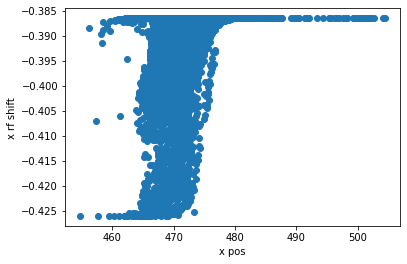

In [25]:
plt.figure()
plt.scatter(eye_pos_matrix[:,1],shifts_matrix[:,1])
plt.ylabel("x rf shift")
plt.xlabel("x pos")
#plt.savefig("D://inception_loop/RGC_sim_data/results/model_eye_v3_1_ellipse_angle_xshift.png")

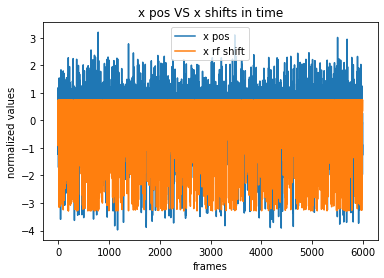

In [24]:
plt.figure()
plt.plot((eye_pos_matrix[:,0]-np.mean(eye_pos_matrix[:,0]))/np.std(eye_pos_matrix[:,0]), label="x pos")
plt.plot((shifts_matrix[:,0]-np.mean(shifts_matrix[:,0]))/np.std(shifts_matrix[:,0]), label="x rf shift")
plt.ylabel("normalized values")
plt.xlabel("frames")
plt.title("x pos VS x shifts in time")
plt.legend()
#plt.savefig("D://inception_loop/RGC_sim_data/results/model_eye_v3_1_ellipse_angle_xshift_time.png")

# Analyze the trained model

### Predict neural responses to an image (here from the train set)

In [ ]:
# show some example images and the neural responses
n_images = 5
max_response = responses[:n_images].max()

for i in range(n_images):
    input_image = images[i]
    predicted_response = model(torch.from_numpy(input_image).view(1,1,36,64).cuda())
    predicted_response = predicted_response.squeeze().cpu().data.numpy()
    
    fig, axs = plt.subplots(1, 3, figsize=(20,4))
    axs[0].imshow(input_image)
    axs[1].plot(responses[i])
    axs[2].plot(predicted_response)
    axs[1].set_xlabel('neurons')
    axs[2].set_xlabel('neurons')
    axs[1].set_ylabel('responses')
    axs[2].set_ylabel('predicted responses')
    axs[1].set_ylim([0, max_response])
    plt.show()

### Get the performance of your model

In [40]:
from lurz2020.utility.measures import get_correlations, get_fraction_oracles

train_correlation = get_correlations(model, dataloaders["train"], device='cuda', as_dict=False, per_neuron=False)
validation_correlation = get_correlations(model, dataloaders["validation"], device='cuda', as_dict=False, per_neuron=False)
test_correlation = get_correlations(model, dataloaders["test"], device='cuda', as_dict=False, per_neuron=False)

# Fraction Oracle can only be computed on the test set. It requires the dataloader to give out batches of repeats of images. 
# This is achieved by building a dataloader with the argument "return_test_sampler=True"
oracle_dataloader = static_loaders(**dataset_config, return_test_sampler=True, tier='test')
fraction_oracle = get_fraction_oracles(model=model, dataloaders=oracle_dataloader, device='cuda')[0]

print('-----------------------------------------')
print('Correlation (train set):      {0:.3f}'.format(train_correlation))
print('Correlation (validation set): {0:.3f}'.format(validation_correlation))
print('Correlation (test set):       {0:.3f}'.format(test_correlation))
print('-----------------------------------------')
print('Fraction oracle (test set):   {0:.3f}'.format(fraction_oracle))

Returning only test sampler with repeats...
-----------------------------------------
Correlation (train set):      0.384
Correlation (validation set): 0.324
Correlation (test set):       0.324
-----------------------------------------
Fraction oracle (test set):   0.836


------------------------------------------